In [93]:
import scipy.cluster.hierarchy as hierarchy
import torch
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib as mpl
from tqdm import tqdm
import tikzplotlib
import torch.nn as nn
from scipy.spatial import distance

## Prepare data

In [94]:
path_to_features = '../features/full1'
path_to_features = '../../../dataset/feats/full1'  #comment this line

path_to_dataset = ''
path_to_dataset = '../../../dataset/miniimagenetimages/' #comment this line

In [95]:
def sphering(features):
    #print('s',features.shape)
    return features / torch.norm(features, p = 2, dim = 2, keepdim = True)

def centering(train_features, features):
    #print('c',features.shape)
    return features - train_features.reshape(-1, train_features.shape[2]).mean(dim = 0).unsqueeze(0).unsqueeze(0)

def preprocess(train_features, features):
    #print('pre',features.shape)
    return sphering(centering(train_features,features))

In [96]:
feat = torch.load(path_to_features,map_location = 'cpu')

In [97]:
feat = preprocess(feat[:64], feat)

In [98]:
file = "../labels/labels_miniINT.txt"
f=open(file,"r")
f.readline()
lines=f.readlines()
result=[]
code = []
for x in lines:
    try:
        result.append(x.split('	')[1][:-1])
        code.append(x.split('	')[0])
    except:
        pass
f.close()

In [99]:
classes = []
for subset in ['train','validation','test']:
    with open(path_to_dataset+ subset + ".csv", "r") as f:
                start = 0
                for line in f:
                    if start == 0:
                        start += 1
                    else:
                        splits = line.split(",")
                        fn, c = splits[0], splits[1][:-1]
                        if c not in classes:
                            classes.append(c)

In [100]:
file = "../labels/labels_miniINT.txt"
f=open(file,"r")
f.readline()
lines=f.readlines()
result=[]
code = []
for x in lines:
    try:
        result.append(x.split('	')[1][:-1])
        code.append(x.split('	')[0])
    except:
        pass
f.close()

In [101]:
labels = []
labels_no_str=[]
for i in range(64):
    cl = classes[i]
    k = code.index(cl)
    labels.append(str(k) + result[k])
    labels_no_str.append(result[k])

## Plot dendrograms

In [102]:
def plot_dendrogram (linked_data, labels, title="", file_name=None) :

    """
        Plots the possible ranges of values.
        --
        In:
            * linked_data: Tree to plot.
            * labels: Labels of the leaves.
            * title: Figure title.
            * file_name: Where to save the results.
        Out:
            * None.
    """

    # Plot
    figure = plt.figure(figsize=(5, 15), constrained_layout=True)
    a = hierarchy.dendrogram(linked_data, orientation="right", labels=labels, leaf_font_size=mpl.rcParams["font.size"], get_leaves=True)
    #plt.title(title)
    figure.gca().spines["right"].set_visible(False)
    figure.gca().spines["left"].set_visible(False)
    figure.gca().spines["bottom"].set_visible(False)
    figure.gca().spines["top"].set_visible(False)
    tikzplotlib.save('dend.tikz')
    return a




### All 100 classes

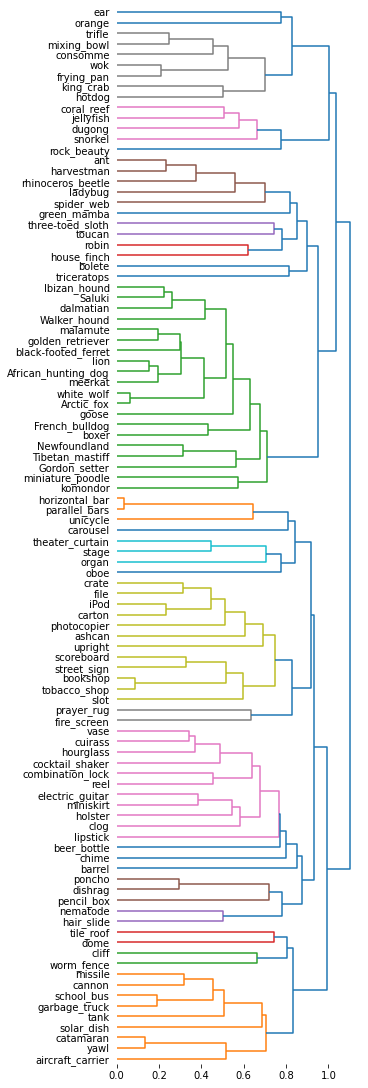

In [106]:
labels = []
for i in range(100):
    cl = classes[i]
    k = code.index(cl)
    labels.append(result[k])
    

shots_barycenters = feat.mean(-2)


linked_data = hierarchy.linkage(shots_barycenters.to('cpu').detach().numpy(), method="average", metric="cosine")
dend = plot_dendrogram(linked_data, labels, title="Dendrogramme")


### Only base and novel

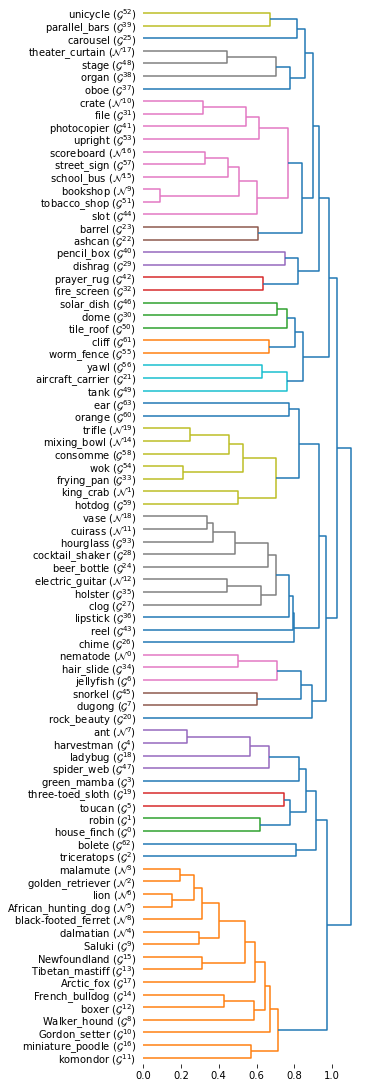

In [105]:
labels = []
labels_clean = []
for i in range(100):
    cl = classes[i]
    k = code.index(cl)
    
    if k>80:
        i_str= i-80
        labels.append(result[k]+ ' '+ '($\mathcal{N}^{'+str(i_str)+'}$)')
    else:
        i_str = i
        labels.append(result[k]+ ' '+ '($\mathcal{G}^{'+str(i_str)+'}$)')
    labels_clean.append(result[k])

shots_basenovel = torch.cat((shots_barycenters[:64], shots_barycenters[-20:]))
labels_basenovel = labels[:64] + labels[-20:]
labels_basenovel_clean = labels_clean[:64] + labels_clean[-20:]



linked_data = hierarchy.linkage(shots_basenovel.to('cpu').detach().numpy(), method="average", metric="cosine")
#labels = ["%s - %d - Test" % (code_to_text[index_to_code["test"][way.item()]], way) for way in ways]
#labels = [result[] for i in range(64)]
#labels= ["lion" for i in range(20)]
dend = plot_dendrogram(linked_data, labels_basenovel, title="Dendrogramme")


## Compute geometry

In [75]:
cosine_matrix = np.zeros((64,20,20,3))
for k in range(64):
    for i in range(20):
        for j in range(20):
            a = distance.cosine(shots_basenovel[64+i], shots_basenovel[64+j])
            b = distance.cosine(shots_basenovel[k], shots_basenovel[64+i])
            c = distance.cosine(shots_basenovel[k], shots_basenovel[64+j])
            cosine_matrix[k,i,j] = np.array([a,b,c])

In [119]:
np.save('../data/cosine_mat.npy', cosine_matrix)

In [79]:
def find_nei(node,n,link,idx):
    try:
        val = node[0].item()
    except:
        return idx
    return  val +n
    

def find_in_dend(nv1,nv2,base, linkage):
    idnv1 = nv1+64
    idnv2 = nv2+64
    idbas = base
    L1,L2,Lbas = [idnv1],[idnv2],[idbas]
    done,count=False,0
    n=linkage.shape[0]+1
    #print(n)
    done12, donebas1,donebas2 = False,False,False
    while (not done) and (count<100):
        count+=1
        node1 = np.where(linked_data[:,:2] == np.float(idnv1))
        node2 = np.where(linked_data[:,:2] == np.float(idnv2))
        nodebas = np.where(linked_data[:,:2] == np.float(base))
        idnv1 = find_nei(node1,n,linked_data,idnv1)
        idnv2  = find_nei(node2,n,linked_data,idnv2)
        base  = find_nei(nodebas,n,linked_data,base)
        L1.append(idnv1)
        L2.append(idnv2)
        Lbas.append(base)
        if idnv1 in L2 and not done12:
            #print('found 1 2')
            #print(L2, idnv1)
            height12 = linkage[idnv1-n,2]
            done12 =True
        if idnv1 in Lbas and not donebas1:
            #print('found 1 bas')
            #print(Lbas, idnv1)
            heightbas1 = linkage[idnv1-n,2]
            donebas1 =True
        if idnv2 in Lbas and not donebas2:
            #print('found 2 base')
            #print(Lbas, idnv2)
            heightbas2 = linkage[idnv2-n,2]
            donebas2 =True
        if idnv2 in L1 and not done12:
            #print('found 1 2')
            #print(L1, idnv2)
            height12 = linkage[idnv2-n,2]
            done12 =True
        if base in L1 and not donebas1:
            #print('found base 1')
            #print(L1, base)
            heightbas1 = linkage[base-n,2]
            donebas1 =True
        if base in L2 and not donebas2:
            #print('found base 2')
            #print(L2, neibor2)
            heightbas2 = linkage[base-n,2]
            donebas2 =True
        done = done12 * donebas1 * donebas2
    return height12, heightbas1,heightbas2

In [118]:
np.save('../data/dendrodist.npy',dendrodist)

## Test remove a class and compare dendrograms

In [110]:
feat2 = torch.load('../features/f11',map_location = 'cpu')
feat2 = preprocess(feat2[:63], feat2)

In [115]:
labels_basenovelm_1 = [labels_basenovel[0]]+labels_basenovel[2:]
means = feat2.mean(1)
shots_basenovel_m_1 = torch.cat((means[0].unsqueeze(0),means[2:64],means[-20:]))

In [116]:
linked_data = hierarchy.linkage(shots_basenovel.to('cpu').detach().numpy(), method="average", metric="cosine")
linked_data2 = hierarchy.linkage(shots_basenovel_m_1.to('cpu').detach().numpy(), method="average", metric="cosine")

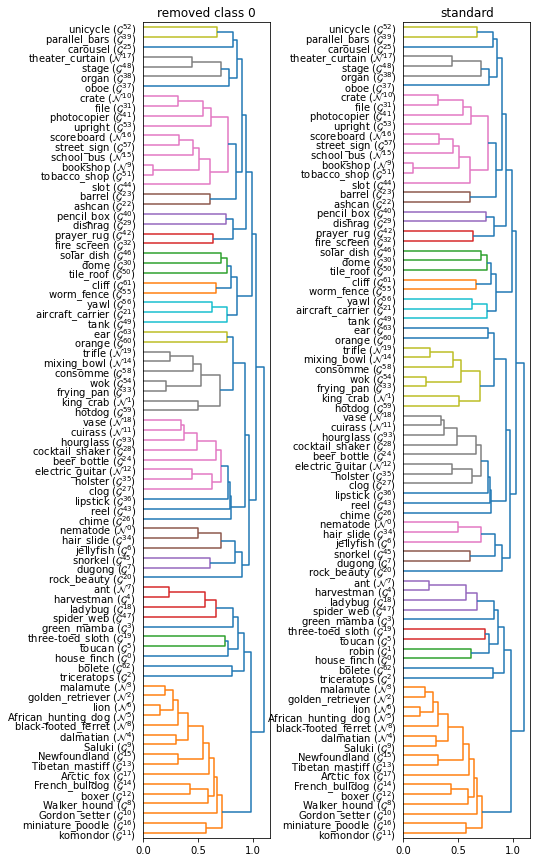

In [117]:
fig,axs = plt.subplots(1,2,figsize=(5, 15))
box = axs[1].get_position()
box.x0 = box.x0 + 0.3
box.x1 = box.x1 + 0.3
axs[1].set_position(box)
axs[0].set_title('removed class 0')
axs[1].set_title('standard')
a = hierarchy.dendrogram(linked_data2,ax= axs[0], orientation="right", labels=labels_basenovelm_1, leaf_font_size=mpl.rcParams["font.size"], get_leaves=True)
b = hierarchy.dendrogram(linked_data,ax =axs[1] ,orientation="right", labels=labels_basenovel, leaf_font_size=mpl.rcParams["font.size"], get_leaves=True)
plt.savefig('dendro.pdf',bbox_inches='tight')